# LM741:

Gather all your knowledge to validate some information from the datasheet of the LM741 :

- Supply the circuit with the right potential, try some different values within the possible
range.
- Generate a sinus and a triangle signal as input with the help of the wave generator.
- Measure with the oscilloscope the input and output.
- Define a protocol of measure in order to make it repeatable.

https://www.ti.com/lit/ds/symlink/lm741.pdf

In [ ]:
from Rigol.RIGOL import RigolInstrument, detect_rigol_instruments

# gen, osc = detect_rigol_instruments(verbose=1)
# gen.close()
# osc.close()

## DS1022 measurement abilities :

### Amplitude / Level
- `VMAX` / `VMIN`: Max / min sample value in the record.
- `VPP`: Peak-to-peak = VMAX − VMIN.
- `VTOP` / `VBASe`: Leveled high / low states (after hysteresis/statistics).
- `VAMP`: Amplitude = VTOP − VBASe (leveled version of VPP).
- `VAVG`: Mean (DC average).
- `VRMS`: RMS including DC.
- `PVRMS`: RMS over one detected period.
- `VUPper` / `VMID` / `VLOWer`: Threshold levels (often 90% / 50% / 10%) used for timing.
- `TVMAX` / `TVMIN`: Time locations of VMAX / VMIN within the record.

### Edges / Slew / Overshoot
- `OVERshoot`: $ \frac{V_{\max}-V_{\text{top}}}{V_{\text{top}}-V_{\text{base}}} \times 100\% $.
- `PREShoot`: $ \frac{V_{\text{base}}-V_{\text{min\_before}}}{V_{\text{top}}-V_{\text{base}}} \times 100\% $.
- `RTIMe` / `FTIMe`: Rise/fall time (typically 10–90% or 20–80% of VLOWer→VUPper).
- `PSLEWrate` / `NSLEWrate`: Positive/negative slew rate, usually $ \Delta V / \Delta t $ on the main edge (often same 10–90% span); returns V/s.
- `PERiod` / `FREQuency`: Period and frequency of the detected fundamental edge sequence.

### Pulse Metrics
- `PWIDth` / `NWIDth`: Positive/negative pulse width (time high / time low).
- `PDUTy` / `NDUTy`: Duty cycle (high/low time ÷ period).
- `PPULses` / `NPULses`: Count of positive/negative pulses.
- `PEDGes` / `NEDGes`: Count of positive/negative edges.
- `MARea` / `MPARea`: Positive/negative area (∫V·dt by polarity).

### Timing Between Channels (needs two sources)
- `RDELay` / `FDELay`: Delay between edges on source A and B (rise→rise, fall→fall).
- `RPHase` / `FPHase`: Phase difference (degrees) between sources on rising or falling edges.

### Variation / Statistics
- `VARIance`: Variance of the waveform samples.
- `PVRMS`: (see above) RMS over one period; useful for periodic signals.

### Source Notes
- Single-source items: most amplitude/edge/pulse metrics; default source is `:MEASure:SOURce` if omitted.
- Two-source items (`RDELay`, `FDELay`, `RPHase`, `FPHase`): need two sources; defaults come from `:MEAS:SETup:DSA/DSB` or `:MEAS:SETup:PSA/PSB`.
- Allowed sources: for timing/phase/delay, `D0..D15`, `CHAN1..4`, `MATH`; for amplitude items, `CHAN1..4`, `MATH`.

### Quick Slew-Rate Use
- Direct: `:MEAS:ITEM? PSLEWrate,CHAN2` (and `NSLEWrate` for falling).
- Or use `RTIMe` (10–90%) with $ \text{SR} \approx 0.8 \cdot V_{\text{pp}} / t_{10\text{–}90} $ (convert to V/µs by dividing by $10^6$).

---
## Bode Diagram and GBW :

Note : to find the graphs of the examples of gain, check `/lab/RIGOL_data_acquisition`

In [20]:
# 1. Empirically get the dB_Gain at 100Hz , substract 3dB from it (target_dB) and sweep to find the frequency where you get this target_dB
    # ex. 
        # G_init = 2 = 20*log2(2) = 6.02 dB
        # fc : G(-3dB) = G_init -3 = 3.02 dB, now find fc such that we have a gain of 3.02 dB

    #! NOTE : select your DC gain well from the freqs list, the first freq is our DC gain reference, make sure it is not too low or high.



# Other (similar) method to find f₋₃dB :
    # G_init = 2 = 6.02 dB
    # G(-3dB) = 3.02 dB
    # reconvertir en lineaire : 10^(3.02/20) = 1.4125 at fc
    # so if Vin = 0.5, then Vout = Vin * 1.4125 = 0.70625 Vpp at fc

    # OR
    # G_fc = G_init / sqrt(2) = 2 / 1.414 = 1.414
    # Find the frequency where the output amplitude drops to the calculated V_(-3dB) value. This frequency is your f₋₃dB.

In [ ]:
import numpy as np

# Convention : CH1 for input, CH2 for output
bandWidth = 1.5e6  # 1.5 MHz for LM741

# === Test 1 : Measure the Gain =========
def check_gain(R1, R2, V_in_pp, freq=1000, verbose=False, plot=False):
    """
    Measure LM741 op-amp gain with non-inverting configuration.
    R1 = feedback resistor (from output to IN-)
    R2 = resistor from IN- to GND
    Expected gain = 1 + R1/R2
    """
    gain_expected = 1 + (R2 / R1)
    V_out_expected = V_in_pp * gain_expected
    
    if verbose:
        print(f"\n=== LM741 Gain Test ===")
        print(f"R1={R1}Ω, R2={R2}Ω → Expected gain: {gain_expected:.3f}")
        print(f"Input: {V_in_pp:.2f} Vpp @ {freq} Hz")
        print(f"Expected output (low frequency): {V_out_expected:.2f} Vpp")
        
    # Connect instruments
    generator, oscilloscope = detect_rigol_instruments(verbose=0)
    if not (oscilloscope and generator):
        print("Error: Instruments not detected!")
        return False
    
    try:
        # Generate sine wave on CH1 (input to LM741)
        generator.generate_waveform(
            channel="CH1", 
            waveform_type="sin", 
            frequency=freq, 
            amplitude=V_in_pp,
            offset=0  # Centered at 0V for dual supply
        )
        time.sleep(2)  # Stabilize
        
        # Enable both channels on scope
        oscilloscope.write(':CHAN1:DISP ON')
        oscilloscope.write(':CHAN2:DISP ON')
        time.sleep(0.5)
        
        # Capture input (CH1) and output (CH2)
        if verbose: print("\nCapturing waveforms...")

        t_in, v_in, _ = capture_waveform(oscilloscope, 'CHAN1', verbose=False)
        t_out, v_out, _ = capture_waveform(oscilloscope, 'CHAN2', verbose=False)
        
        # Calculate measurements
        V_in_measured = np.max(v_in) - np.min(v_in)
        V_out_measured = np.max(v_out) - np.min(v_out)
        gain_measured = V_out_measured / V_in_measured if V_in_measured > 0 else 0
        gain_db = 20 * np.log10(gain_measured) if gain_measured > 0 else -np.inf
        # error_pct = abs(gain_measured - gain_expected) / gain_expected * 100

        # Results
        if verbose:
            print(f"\n=== Results ===")
            print(f"  Input  Vpp:  {V_in_measured:.4f} V")
            print(f"  Output Vpp:  {V_out_measured:.4f} V")
            print(f"  Gain (V/V):  {gain_measured:.4f}")
            print(f"  Gain (dB):   {gain_db:.2f} dB")
            
        # Quick plot
        if plot :
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7))
            # Input signal
            ax1.plot(t_in * 1e3, v_in, linewidth=1.5, color='steelblue', label=f'Input: {V_in_measured:.3f} Vpp')
            ax1.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            ax1.set_ylabel('Voltage (V)', fontsize=11)
            ax1.set_title(f'LM741 Gain Measurement: R1={R1/1e3:.1f}kΩ, R2={R2/1e3:.1f}kΩ @ {freq/1e3:.1f} kHz', 
                fontsize=12, fontweight='bold')
            ax1.grid(True, alpha=0.3)
            ax1.legend(fontsize=10)
            
            # Output signal
            ax2.plot(t_out * 1e3, v_out, linewidth=1.5, color='darkorange', 
                    label=f'Output: {V_out_measured:.3f} Vpp | Gain: {gain_measured:.3f} ({gain_db:.2f} dB)')
            ax2.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
            ax2.set_xlabel('Time (ms)', fontsize=11)
            ax2.set_ylabel('Voltage (V)', fontsize=11)
            ax2.grid(True, alpha=0.3)
            ax2.legend(fontsize=10)
            
            plt.tight_layout()
            plt.show()
        
        return {
            'frequency': freq,
            'gain_expected': gain_expected,
            'gain_measured': gain_measured,
            'gain_db': gain_db,
            'v_in': V_in_measured,
            'v_out': V_out_measured
        }
        
    finally:
        generator.close()
        oscilloscope.close()


# === Test 2: Find the cutoff frequency at a given gain =========
def bode_diagram(R1, R2, V_in_pp, frequencies, GBW=1.5e6, plot=True):
    gain_expected = 1 + (R2 / R1)
    f_3db_theoretical = GBW / gain_expected
    
    print(f"\n{'='*70}")
    print(f"LM741 FREQUENCY RESPONSE ANALYSIS (Bode Magnitude Diagram)")
    print(f"{'='*70}")
    print(f"Configuration:")
    print(f"  R1 (feedback) = {R1/1e3:.1f} kΩ")
    print(f"  R2 (ground)   = {R2/1e3:.1f} kΩ")
    print(f"  DC Gain       = {gain_expected:.3f} ({20*np.log10(gain_expected):.2f} dB)")
    print(f"  Input Signal  = {V_in_pp:.3f} Vpp")
    print(f"  GBW           = {GBW/1e6:.2f} MHz")
    print(f"  Theoretical -3dB Frequency = {f_3db_theoretical/1e3:.1f} kHz")
    print(f"{'─'*70}")
    print(f"Testing {len(frequencies)} frequency points from {frequencies[0]/1e3:.1f} kHz to {frequencies[-1]/1e6:.2f} MHz")
    print(f"{'='*70}\n")
    
    results = []
    for i, freq in enumerate(frequencies, 1):
        print(f"[{i}/{len(frequencies)}] Testing {freq/1e3:.1f} kHz...", end=' ')
        result = check_gain(R1=R1, R2=R2, V_in_pp=V_in_pp, freq=freq, verbose=False, plot=False)
        
        if result: 
            results.append(result)
            print(f"✓ Gain: {result['gain_measured']:.3f} ({result['gain_db']:.2f} dB)")
        else:
            print("✗ Measurement failed"); 
            break
        time.sleep(1)
    
    # Extract data for plotting
    freqs_measured = [r['frequency'] for r in results]
    gains_linear = [r['gain_measured'] for r in results]
    gains_db = [r['gain_db'] for r in results]
    
    # Set DC gain reference at 1000 Hz
    dc_gain_db = gains_db[0] if gains_db else 0
    print(f"\nDC Gain (our selected reference) at {freqs_measured[0]/1e3:.1f} kHz: {dc_gain_db:.2f} dB")
    # Find -3dB point (where gain drops by 3dB from DC gain) 
    target_db = dc_gain_db - 3

    f_3db_measured = None
    for i, gain_db in enumerate(gains_db):
        # check when we have a greater attenuation than 3dB
        if gain_db <= target_db:
            # Linear interpolation (need at least 2 measurements points)
            if i > 0:
                print(f"Interpolating -3dB point between {freqs_measured[i-1]/1e3:.1f} kHz ({gains_db[i-1]:.2f} dB) and {freqs_measured[i]/1e3:.1f} kHz ({gains_db[i]:.2f} dB)")
                print(f"Theoretical dB: {target_db:.2f} dB vs actual selected dB: {gain_db[i]:.2f} dB")
                f1, f2 = freqs_measured[i-1], freqs_measured[i]
                g1, g2 = gains_db[i-1], gains_db[i]
                f_3db_measured = f1 + (target_db - g1) * (f2 - f1) / (g2 - g1)
            else:
                f_3db_measured = freqs_measured[i]
            break
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"📊 FREQUENCY RESPONSE SUMMARY")
    print(f"{'='*70}")
    print(f"DC Gain ({dc_gain_db} Hz):        {gains_linear[0]:.3f} V/V ({gains_db[0]:.2f} dB)")
    if f_3db_measured:
        print(f"Measured -3dB Cutoff:    {f_3db_measured/1e3:.1f} kHz")
        # print(f"Theoretical -3dB Cutoff: {f_3db_theoretical/1e3:.1f} kHz")
        # error_f3db = abs(f_3db_measured - f_3db_theoretical) / f_3db_theoretical * 100
        # print(f"Error:                   {error_f3db:.1f}%")
    else:
        print(f"Measured -3dB Cutoff:    Not reached in test range")
    print(f"Gain @ 1 MHz:            {gains_linear[-1]:.3f} V/V ({gains_db[-1]:.2f} dB)")
    print(f"{'='*70}\n")
    

    if plot:
        # Plot Bode diagram
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Plot measured data
        ax.semilogx(freqs_measured, gains_db, 'o-', linewidth=2, markersize=8, 
                    color='steelblue', label='Measured Gain', zorder=3)
        
        # Plot -3dB line (horizontal reference)
        ax.axhline(dc_gain_db - 3, color='gray', linestyle=':', linewidth=1.5, 
                    alpha=0.7, label=f'-3dB point ({dc_gain_db-3:.2f} dB)')
    
        # Plot measured -3dB frequency (vertical line + marker)
        if f_3db_measured:
            ax.axvline(f_3db_measured, color='green', liy_referencenestyle='--', linewidth=2, 
                    alpha=0.7, label=f'Measured f₋₃ₐᵦ = {f_3db_measured/1e3:.1f} kHz')
            ax.plot(f_3db_measured, target_db, 'go', markersize=12, zorder=4)
            
            # Calculate measured GBW
            measured_gbw = f_3db_measured * gain_expected
            gbw_text = f'Measured GBW = {measured_gbw/1e6:.2f} MHz'
        else:
            gbw_text = 'GBW: Not determined (f₋₃ₐᵦ not reached)'
        
        # Labels and formatting
        ax.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Gain (dB)', fontsize=12, fontweight='bold')
        ax.set_title(f'LM741 Bode Magnitude Diagram\nR1={R1/1e3:.1f}kΩ, R2={R2/1e3:.1f}kΩ, Gain={gain_expected:.1f} ({20*np.log10(gain_expected):.1f} dB)', 
                    fontsize=14, fontweight='bold', pad=20)
        ax.grid(True, which='both', alpha=0.3, linestyle='-', linewidth=0.5)
        ax.grid(True, which='minor', alpha=0.1, linestyle='-', linewidth=0.3)
        ax.legend(fontsize=11, loc='upper right')
        
        # Add text annotation with key parameters
        textstr = f'DC Gain = {gain_expected:.1f} ({20*np.log10(gain_expected):.1f} dB)\n{gbw_text}'
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    return {
        'frequencies': freqs_measured,
        'gains_linear': gains_linear,
        'gains_db': gains_db,
        'f_3db_theoretical': f_3db_theoretical,
        'f_3db_measured': f_3db_measured,
        'results': results
    }


### Bode (Gain=2) :

In [ ]:


# GAIN = 1+10/10 = 2
r1 = 10000  # 10kΩ
r2 = 10000   # 10kΩ


freqs = [1e3, 10e3, 50e3, 100e3, 300e3, 500e3, 750e3, 1e6, 1.5e6, 2e6]

bode_data = bode_diagram(
    R1=r1, 
    R2=r2, 
    V_in_pp=0.5, 
    frequencies=freqs, 
    GBW=1.5e6
)


### High Gain (11.0) :

In [ ]:
# HIGH Gain = 1 + 10/1 = 11
r1 = 1000  # 1kΩ
r2 = 10000   # 10kΩ

freqs = [10e3, 50e3, 100e3, 150e3, 200e3, 300e3, 500e3, 750e3, 1e6, 1.5e6, 2e6]

bode_data = bode_diagram(
    R1=r1, 
    R2=r2, 
    V_in_pp=0.5, 
    frequencies=freqs, 
    GBW=1.5e6
)



### Medium Gain (6.0) :

In [ ]:
# MEDIUM Gain = 1 + 10/2 = 6
r1 = 1000  # 1kΩ
r2 = 2000   # 2kΩ

# check_gain(R1 = r1, R2 = r2, V_in_pp = 0.5, freq=1000, verbose=True, plot=False)

freqs = [1e3, 10e3, 50e3, 100e3, 150e3, 200e3, 300e3, 500e3, 750e3, 1e6, 1.5e6, 2e6]

bode_data = bode_diagram(
    R1=r1, 
    R2=r2, 
    V_in_pp=0.5, 
    frequencies=freqs, 
    GBW=1.5e6
)



### Low Gain (1.1) :

In [ ]:
# LOW GAIN = 1 + 1/10 = 1.1
r1 = 10000   # 10kΩ
r2 = 1000   # 1kΩ


# Check gain
check_gain(R1 = r1, R2 = r2, V_in_pp = 0.5, freq=1000, verbose=True, plot=False)

freqs = [1e3, 10e3, 100e3, 300e3, 500e3, 600e3, 650e3, 700e3, 750e3, 1e6, 1.5e6, 2e6]

bode_data = bode_diagram(
    R1=r1, 
    R2=r2, 
    V_in_pp=0.5, 
    frequencies=freqs, 
    GBW=1.5e6
)



---
## Output Voltage Swing :

_Examples with :_
- Sinusoidal
- frequency : 1000 Hz

_Expected to find :_
- Idea: vary Vin until you observe clipping in Vout (e.g. gain makes Vout > than the Vsupply).
- Vsupply at +- 15V ---> Vclipping is at Vin=13.6Vpp


_Finally:_
- Automated detection of clipping given a signal and its Vsupply.


In [3]:
import json
import os
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import time

from Rigol.DS1104ZPLUS import capture_waveform, save_waveform_capture, load_waveform_capture

In [1]:
def detect_clipping(voltage_array, y_increment, threshold_pct=90, verbose=False):
    """
    Detect clipping by analyzing the SHAPE of the waveform.
    
    KEY INSIGHT: A clipped sine has a DISCONTINUITY (sharp corner) at the clip point.
    A clean sine is always smooth (curved). We detect this by analyzing the
    distribution of slopes and looking for JUMPS.
    
    Args:
        voltage_array: Voltage samples from oscilloscope
        y_increment: ADC resolution (V per LSB)
        threshold_pct: Percentile for peak region (default 90%)
        verbose: Print debugging info
    
    Returns:
        is_clipping (bool), clipping_indicator (float 0-1)
    """
    
    if len(voltage_array) < 50:
        return False, 0.0
    
    # ========== APPROACH: Compare peak region to what a sine should be ==========
    
    # 1. Get statistics of the full waveform
    v_min = np.min(voltage_array)
    v_max = np.max(voltage_array)
    v_amplitude = (v_max - v_min) / 2.0  # Half the peak-to-peak
    v_center = (v_max + v_min) / 2.0     # DC center
    
    if v_amplitude < y_increment * 5:
        return False, 0.0  # Signal too small
    
    # 2. Calculate first derivative (slope)
    # Use minimal smoothing to preserve edges (which appear at clips)
    smoothed = np.convolve(voltage_array, np.ones(3)/3, mode='same')
    derivative = np.diff(smoothed)
    abs_derivative = np.abs(derivative)
    
    # 3. Identify peak region: voltages within 85% to 100% of max amplitude
    #    This captures the actual peak, not the whole upper 40%
    peak_low = v_center + v_amplitude * 0.85
    peak_high = v_center + v_amplitude * 1.0
    peak_mask_pos = (voltage_array >= peak_low) & (voltage_array <= peak_high + y_increment * 10)
    
    # Do the same for negative peak
    peak_low_neg = v_center - v_amplitude * 0.85
    peak_high_neg = v_center - v_amplitude * 1.0
    peak_mask_neg = (voltage_array <= peak_low_neg) & (voltage_array >= peak_high_neg - y_increment * 10)
    
    peak_mask = peak_mask_pos | peak_mask_neg
    
    if np.sum(peak_mask) < 10:
        return False, 0.0
    
    # 4. Analyze the peak region for clipping signatures
    # 
    # CLEAN SINE at peak:
    #   - Smooth curve: derivative slowly increases then decreases
    #   - Max slope in peak region: ~0.5-2% of max slope in whole waveform
    #   - Pattern: gradual change
    #
    # CLIPPED SINE at peak:
    #   - Sharp corner at clip point: sudden jump from ~0 to large slope
    #   - Flat region: many consecutive near-zero slopes
    #   - Pattern: [0, 0, 0, 0, JUMP, large_slope, ...]
    
    peak_derivatives = abs_derivative[peak_mask[:-1]]
    
    if len(peak_derivatives) == 0:
        return False, 0.0
    
    # 5. Calculate clipping indicators
    
    # Indicator 1: Ratio of near-zero slopes in peak (more strict)
    #   For clean sine: ~5-15% of peak region has very small slopes
    #   For clipped sine: >50% has near-zero slopes
    flatness_threshold = y_increment * 0.5  # MUCH TIGHTER (was 2.0)
    flat_count = np.sum(peak_derivatives < flatness_threshold)
    flatness_ratio = flat_count / len(peak_derivatives)
    
    # Indicator 2: Look for discontinuity (jump in slope)
    #   Clipping has: derivative suddenly changes (e.g., 0.00 → 1.50)
    #   Clean sine has: smooth transitions
    if len(peak_derivatives) > 5:
        slope_changes = np.diff(peak_derivatives)
        large_jumps = np.sum(np.abs(slope_changes) > (y_increment * 5))
        jump_ratio = large_jumps / len(slope_changes)
    else:
        jump_ratio = 0.0
    
    # Indicator 3: Max slope in peak region vs whole waveform
    #   Clipping limits the slope at peak
    #   Clean sine has slopes that scale with amplitude
    max_slope_in_peak = np.max(peak_derivatives) if len(peak_derivatives) > 0 else 0
    max_slope_overall = np.max(abs_derivative) if len(abs_derivative) > 0 else 1
    slope_ratio = max_slope_in_peak / (max_slope_overall + 1e-9)
    
    if verbose:
        print(f"\n[CLIPPING ANALYSIS DEBUG]")
        print(f"  Amplitude: {v_amplitude:.4f}V, Center: {v_center:.4f}V")
        print(f"  y_increment: {y_increment:.6f}V")
        print(f"  Peak region samples: {np.sum(peak_mask)}")
        print(f"  Flatness ratio: {flatness_ratio:.4f} (threshold: >0.30)")
        print(f"  Jump ratio: {jump_ratio:.4f} (threshold: >0.20)")
        print(f"  Slope ratio (peak/max): {slope_ratio:.4f}")
        print(f"  Clipping decision: {(flatness_ratio > 0.30) and (jump_ratio > 0.20)}")
    
    # 6. FINAL DECISION: Both indicators must suggest clipping
    #    This avoids false positives from either metric alone
    is_clipping = (flatness_ratio > 0.30) and (jump_ratio > 0.20)
    
    # Clipping indicator: 0-1 scale
    clipping_indicator = min(1.0, flatness_ratio + jump_ratio) / 2.0
    
    return is_clipping, clipping_indicator

In [4]:

def analyze_saved_waveform_for_clipping(filepath, threshold_pct=95, plot=True, verbose=True):
    """
    Load a saved waveform and analyze it for clipping.
    
    This is useful for post-processing captured data without needing the instruments
    connected, or for batch analysis of multiple waveforms.
    
    Args:
        filepath: Path to saved waveform (.npz or .json file)
        threshold_pct: Peak region percentile for clipping detection (default 95%)
        plot: Show waveform with clipping indicator
        verbose: Print analysis results
    
    Returns:
        dict with keys:
            'is_clipping': Bool, True if clipping detected
            'clipping_indicator': Float 0-1, flatness metric
            'voltage_array': The waveform samples
            'preamble': Oscilloscope metadata
            'metadata': User metadata from capture
            'analysis': {
                'v_min': Minimum voltage (V)
                'v_max': Maximum voltage (V)
                'v_peak_to_peak': Peak-to-peak voltage (V)
                'v_mean': Mean voltage (V)
                'v_std': Std dev of voltage (V)
                'clipping_threshold': Voltage level used for peak detection
            }
    """
    # Load waveform
    waveform = load_waveform_capture(filepath)
    time_array = waveform['time_array']
    voltage_array = waveform['voltage_array']
    preamble = waveform['preamble']
    metadata = waveform['metadata']
    
    # Get ADC resolution from preamble
    y_increment = preamble['y_increment']
    
    # Perform clipping detection
    is_clipping, flatness = detect_clipping(voltage_array, y_increment, threshold_pct=threshold_pct)
    
    # Calculate statistics
    v_min = float(np.min(voltage_array))
    v_max = float(np.max(voltage_array))
    v_pp = v_max - v_min
    v_mean = float(np.mean(voltage_array))
    v_std = float(np.std(voltage_array))
    
    # Clipping threshold (for reference)
    clipping_threshold = np.percentile(np.abs(voltage_array), threshold_pct)
    
    analysis = {
        'v_min': v_min,
        'v_max': v_max,
        'v_peak_to_peak': v_pp,
        'v_mean': v_mean,
        'v_std': v_std,
        'clipping_threshold': float(clipping_threshold),
        'num_samples': len(voltage_array),
        'duration_ms': (time_array[-1] - time_array[0]) * 1e3 if len(time_array) > 1 else 0
    }
    
    if verbose:
        print(f"\n{'='*70}")
        print(f"CLIPPING ANALYSIS: {Path(filepath).stem}")
        print(f"{'='*70}")
        print(f"Metadata: {metadata}")
        print(f"{'─'*70}")
        print(f"Waveform Statistics:")
        print(f"  Samples:        {analysis['num_samples']}")
        print(f"  Duration:       {analysis['duration_ms']:.3f} ms")
        print(f"  Vmin:           {v_min:.4f} V")
        print(f"  Vmax:           {v_max:.4f} V")
        print(f"  Vpp:            {v_pp:.4f} V")
        print(f"  Vmean:          {v_mean:.4f} V")
        print(f"  Vstd:           {v_std:.4f} V")
        print(f"{'─'*70}")
        print(f"Clipping Detection:")
        print(f"  Status:         {'🔴 CLIPPING DETECTED' if is_clipping else '🟢 NO CLIPPING'}")
        print(f"  Flatness Ratio: {flatness:.4f} (threshold: 0.30)")
        print(f"  Peak Threshold: {clipping_threshold:.4f} V ({threshold_pct}th percentile)")
        print(f"{'='*70}\n")
    
    # Optional plotting
    if plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
        
        # Plot 1: Full waveform
        ax1.plot(time_array * 1e3, voltage_array, 'b-', linewidth=1.5, label='Waveform')
        ax1.axhline(v_max, color='red', linestyle='--', alpha=0.5, label=f'Max: {v_max:.3f}V')
        ax1.axhline(v_min, color='red', linestyle='--', alpha=0.5, label=f'Min: {v_min:.3f}V')
        ax1.axhline(v_mean, color='green', linestyle=':', alpha=0.5, label=f'Mean: {v_mean:.3f}V')
        ax1.set_ylabel('Voltage (V)', fontsize=11, fontweight='bold')
        ax1.set_title(f'Waveform Analysis: {Path(filepath).stem}\nStatus: {"🔴 CLIPPING" if is_clipping else "🟢 CLEAN"}',
                     fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='upper right')
        
        # Plot 2: Peak region highlighting (for clipping visualization)
        peak_threshold_v = np.percentile(np.abs(voltage_array), threshold_pct)
        peak_mask = np.abs(voltage_array) > peak_threshold_v
        
        ax2.plot(time_array * 1e3, voltage_array, 'b-', linewidth=1.5, alpha=0.5, label='Waveform')
        ax2.scatter(time_array[peak_mask] * 1e3, voltage_array[peak_mask], 
                   c='red', s=20, alpha=0.7, label=f'Peak Region (>{threshold_pct}th %ile)')
        ax2.axhline(peak_threshold_v, color='orange', linestyle='--', linewidth=1.5, 
                   label=f'Peak Threshold: {peak_threshold_v:.3f}V')
        ax2.axhline(-peak_threshold_v, color='orange', linestyle='--', linewidth=1.5)
        ax2.set_xlabel('Time (ms)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Voltage (V)', fontsize=11, fontweight='bold')
        ax2.set_title(f'Peak Region Detection (Flatness: {flatness:.3f}, Threshold: {0.30})',
                     fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'is_clipping': is_clipping,
        'clipping_indicator': flatness,
        'voltage_array': voltage_array,
        'time_array': time_array,
        'preamble': preamble,
        'metadata': metadata,
        'analysis': analysis
    }


In [16]:
# Manually adjust your generator and capture the waveform + SAVE it locally.

fileCLIPPING = '../saves/lm741_output_1khz_gain2.npz'                  # CLIPPING
fileNOCLIPPING = '../saves/lm741_output_1khz_gain_NO_CLIPPING.npz'       # NO CLIPPING
fileALMOSTCLIPPING = '../saves/lm741_output_1khz_gain_ALMOST_CLIPPING.npz'  # ALMOST CLIPPING

if False: 
    result = analyze_saved_waveform_for_clipping(
        filename,
        plot=True,
        verbose=True
    )
    # Check results
    print(f"Clipping: {result['is_clipping']}")
    print(f"Vpp: {result['analysis']['v_peak_to_peak']:.3f}V")


### Clipping:


CLIPPING ANALYSIS: lm741_output_1khz_gain2
Metadata: {'frequency': 1000, 'gain': 2, 'input_vpp': 0.5, 'channel': 'CHAN2'}
──────────────────────────────────────────────────────────────────────
Waveform Statistics:
  Samples:        1200
  Duration:       59.950 ms
  Vmin:           -12.9192 V
  Vmax:           13.2808 V
  Vpp:            26.2000 V
  Vmean:          0.0000 V
  Vstd:           9.5958 V
──────────────────────────────────────────────────────────────────────
Clipping Detection:
  Status:         🟢 NO CLIPPING
  Flatness Ratio: 0.2370 (threshold: 0.30)
  Peak Threshold: 13.0808 V (95th percentile)



/tmp/ipykernel_42967/1313025399.py:119: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/vass/dev/hardware_testing_processes/data_acquisition_RIGOL_Oscillator_and_function_generator/HTP_venv/lib64/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


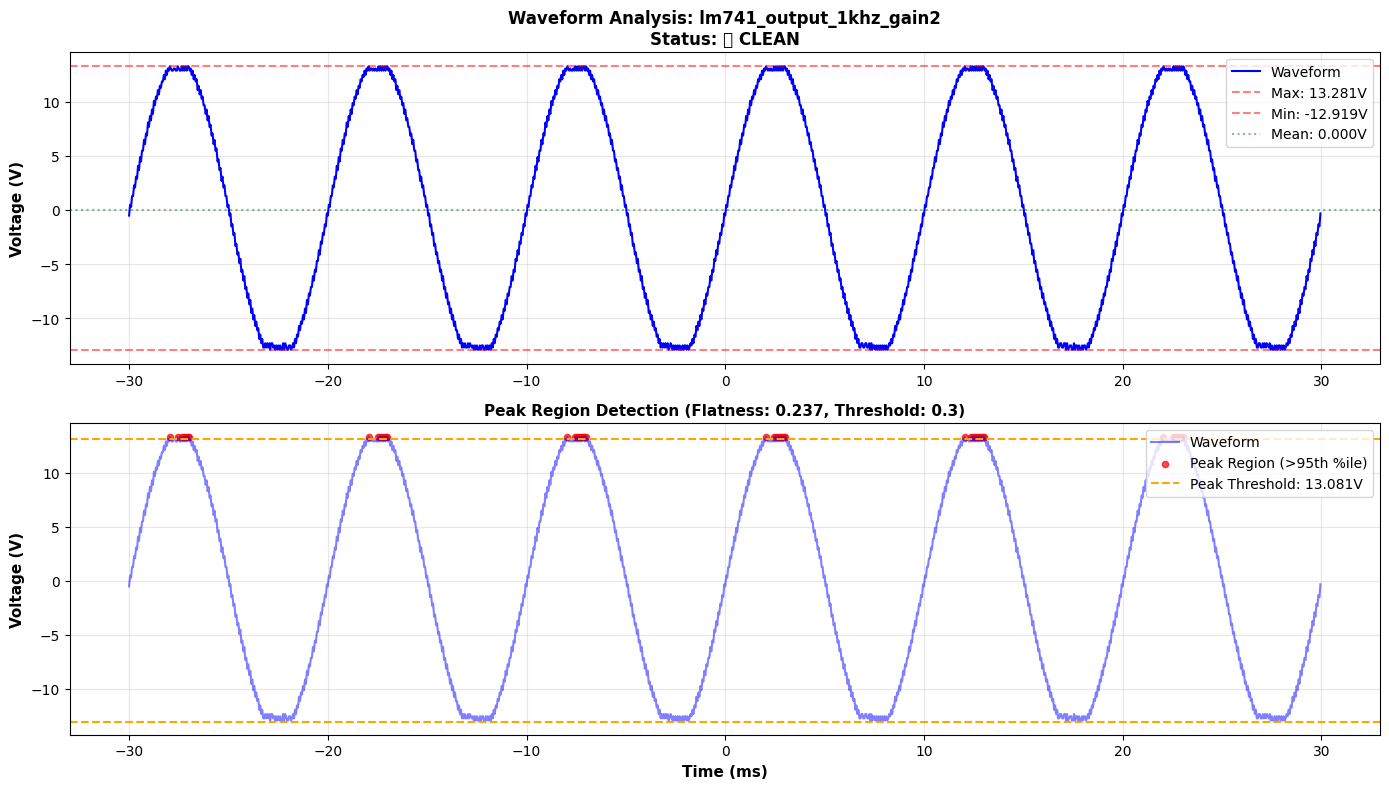

Clipping: False
Vpp: 26.200V


In [17]:
# EXAMPLE CLIPPING DETECTED
result = analyze_saved_waveform_for_clipping(
    fileCLIPPING,
    plot=True,
    verbose=True
)

# Check results
print(f"Clipping: {result['is_clipping']}")
print(f"Vpp: {result['analysis']['v_peak_to_peak']:.3f}V")

### Almost clipping :


CLIPPING ANALYSIS: lm741_output_1khz_gain_ALMOST_CLIPPING
Metadata: {'frequency': 1000, 'gain': 2, 'input_vpp': 0.5, 'channel': 'CHAN2'}
──────────────────────────────────────────────────────────────────────
Waveform Statistics:
  Samples:        1200
  Duration:       1.199 ms
  Vmin:           -12.9423 V
  Vmax:           13.2577 V
  Vpp:            26.2000 V
  Vmean:          -0.0000 V
  Vstd:           8.7545 V
──────────────────────────────────────────────────────────────────────
Clipping Detection:
  Status:         🟢 NO CLIPPING
  Flatness Ratio: 0.1873 (threshold: 0.30)
  Peak Threshold: 12.9423 V (95th percentile)



/tmp/ipykernel_42967/1313025399.py:119: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


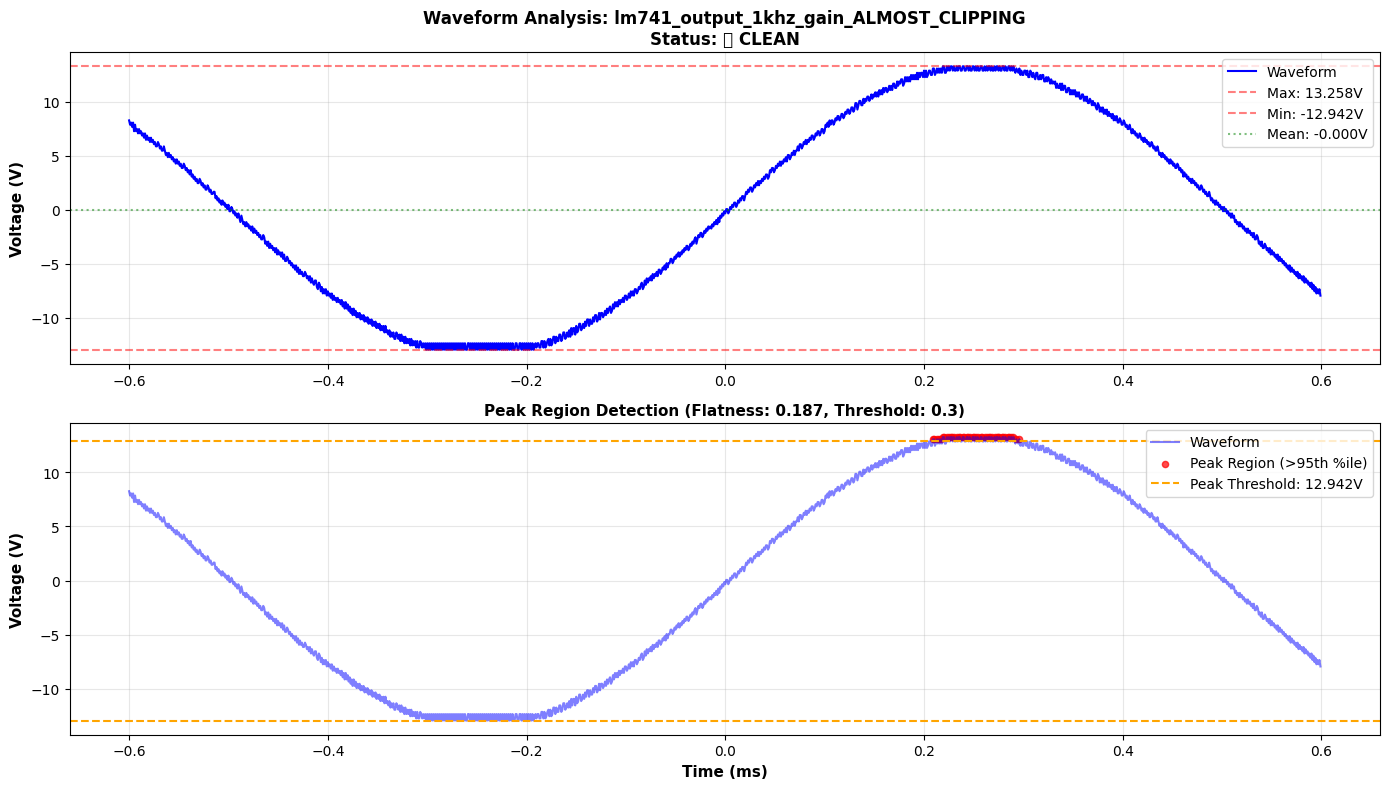

Clipping: False
Vpp: 26.200V


In [18]:
# EXAMPLE ALMOST CLIPPING - 13.5Vpp (clips at 13.6Vpp)
result = analyze_saved_waveform_for_clipping(
    fileALMOSTCLIPPING,
    plot=True,
    verbose=True
)

# Check results
print(f"Clipping: {result['is_clipping']}")
print(f"Vpp: {result['analysis']['v_peak_to_peak']:.3f}V")

### No Clipping :


CLIPPING ANALYSIS: lm741_output_1khz_gain_NO_CLIPPING
Metadata: {'frequency': 1000, 'gain': 2, 'input_vpp': 0.5, 'channel': 'CHAN2'}
──────────────────────────────────────────────────────────────────────
Waveform Statistics:
  Samples:        1200
  Duration:       5.995 ms
  Vmin:           -10.2447 V
  Vmax:           10.1553 V
  Vpp:            20.4000 V
  Vmean:          0.0000 V
  Vstd:           7.0477 V
──────────────────────────────────────────────────────────────────────
Clipping Detection:
  Status:         🟢 NO CLIPPING
  Flatness Ratio: 0.2044 (threshold: 0.30)
  Peak Threshold: 10.1553 V (95th percentile)



/tmp/ipykernel_42967/1313025399.py:119: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


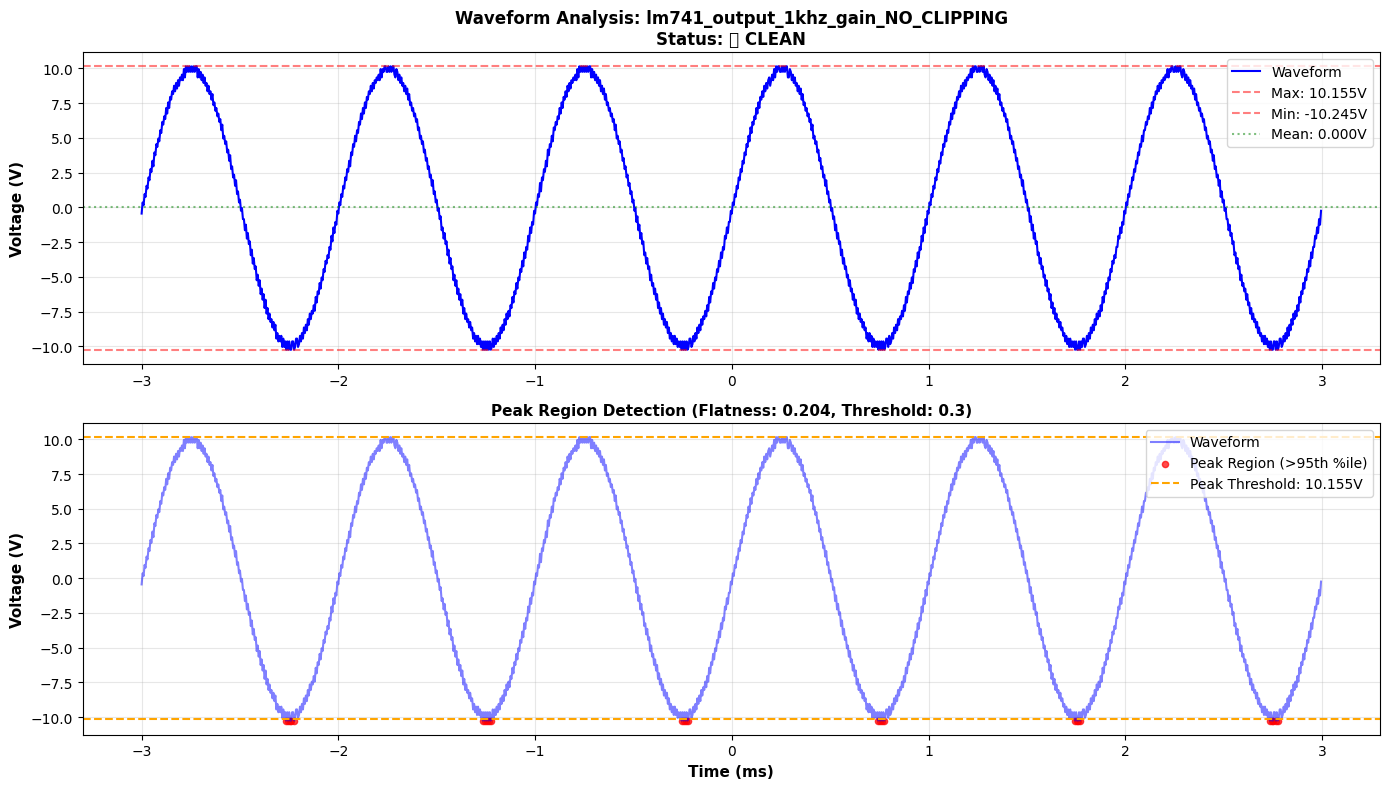

Clipping: False
Vpp: 20.400V


In [19]:
# EXAMPLE NO CLIPPING
result = analyze_saved_waveform_for_clipping(
    fileNOCLIPPING,
    plot=True,
    verbose=True
)

# Check results
print(f"Clipping: {result['is_clipping']}")
print(f"Vpp: {result['analysis']['v_peak_to_peak']:.3f}V")

### Automated Clip detection :

---
## Slew-Rate :

Slew rate is the maximum speed at which the output voltage of an operational amplifier can change.

- To measure slew rate, apply a step signal to the amplifier, then observe the rate of voltage change from 10% to 90% of its maximum amplitude using an oscilloscope.

Method :
- Appy a sinus of high frequency (20 - 50kHz)
- Progresively increase Vin until you get a ramp on Vout.
- Compute SR ≈ 2π · f · Vpeak_out



#### Manual method :

In [ ]:
# Method : 
    # 1. capture the waveform in time and voltage
    # 2. compute the change of those ΔV and Δt
    # 3. compute the slope ΔV / Δt (signed -> apply abs to only get magnitude in +)

    # 4. smooth out singular spikes by selecting only the 99th percentile
    # 5. find the point k with the greatest slope (where is this point on the square signal ? 10%, 90%, in the middle ??)
    # 6. based on this k select the 10% and 90%

    # 7. compute the time and voltage between those points
    # 8. apply the SR formula


# Note: 
    # - this method samples a local slope (could be 40%-60% range) based on the selected window "W" width, not the full transition (10%-90%).
    # - Δt/ΔV works for any voltage range, but less errors occurs at the largest range possible i.e. 10%-90% of the transition.

    # - 99th percentile means selecting the value where 99% of all the values are below it, in order to disregard spikes and noise.



In [ ]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

SCOPE_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"

rm = pyvisa.ResourceManager()
scope = rm.open_resource(SCOPE_ID)
scope.timeout = 10000
scope.write_termination = "\n"
scope.read_termination  = "\n"
scope.encoding = "ascii"

print("SCOPE:", scope.query("*IDN?").strip())

scope.write(":STOP")
scope.write(":WAV:FORM ASC")   # or use BYTE instead of ASCII
scope.write(":WAV:MODE NORM")

def read_waveform(chan: str):
    scope.write(f":WAV:SOUR {chan}")
    pre = scope.query(":WAV:PRE?").strip().split(",")

    xinc  = float(pre[4])
    xorig = float(pre[5])
    xref  = float(pre[6])
    yinc  = float(pre[7])
    yorig = float(pre[8])
    yref  = float(pre[9])

    raw = scope.query(":WAV:DATA?")

    if raw.startswith("#"):
        nd = int(raw[1])
        nb = int(raw[2:2+nd])
        raw = raw[2+nd:2+nd+nb]

    adc = np.array([float(v) for v in raw.split(",") if v.strip() != ""])
    i = np.arange(adc.size)
    t = (i - xref) * xinc + xorig
    v = (adc - yref) * yinc + yorig
    return t, v


# capture_waveform
    # preamble_dict = {
    #             'points': points,
    #             'x_increment': x_increment,
    #             'x_origin': x_origin,
    #             'y_increment': y_increment,
    #             'y_origin': y_origin,
    #             'y_reference': y_reference
    #         }
            
    #         if verbose: print(f"  ✓ Captured {len(y_data)} points successfully")
    #         return time_axis, y_data, preamble_dict
        




# Return time and voltage for CH1 an 2
t1, v1 = read_waveform("CHAN1")
t2, v2 = read_waveform("CHAN2")

scope.write(":RUN")
scope.close()
rm.close()

def vpp(x): return float(np.max(x) - np.min(x))

Vpp_in  = vpp(v1)   # Vpp of input channel
Vpp_out = vpp(v2)   # Vpp of output channel
gain = Vpp_out / Vpp_in if Vpp_in else np.nan

# =========================
# Slew rate "rapport": ΔV / Δt sur la pente max
# =========================
dv = np.diff(v2)    # ΔV
dt = np.diff(t2)    # Δt

slope = dv / dt                # V/s (signé)
abs_slope = np.abs(slope)     # put all in positive

# Option anti-bruit : on prend le 99e percentile au lieu du max brut
target = np.quantile(abs_slope, 0.99)   # avoid singular noise spikes misreads

# index du point le plus proche de ce target
k = int(np.argmin(np.abs(abs_slope - target)))  # after removing noise, find point with biggest change in slope

# fenêtre autour de k (en points)
W = 20  # ajuste 10-50 selon ton scope
i0 = max(0, k - W//2)           # start index of window, clamped at 0
i1 = min(len(v2)-1, k + W//2)   # end index of window, clamped at max index

tA, vA = t2[i0], v2[i0]    # start point of slope (10% of max magnitude)
tB, vB = t2[i1], v2[i1]     # end point of slope (90%)

dT = tB - tA        # Δt across the slew region
dV = vB - vA        # ΔV across the slew region

SR = abs(dV / dT) / 1e6    # Slew rate estimate in V/µs (/1e6 to convert V/s to V/µs)

print("\n=== MESURES ===")
print(f"Vpp_in  = {Vpp_in:.3f} V")
print(f"Vpp_out = {Vpp_out:.3f} V")
print(f"Gain    = {gain:.3f}")

print("\n=== SLEW RATE (méthode ΔV/Δt) ===")
print(f"tA = {tA*1e6:.3f} µs,  vA = {vA:.3f} V")
print(f"tB = {tB*1e6:.3f} µs,  vB = {vB:.3f} V")
print(f"Δt = {dT*1e6:.3f} µs")
print(f"ΔV = {dV:.3f} V")
print(f"Slew rate ≈ {SR:.3f} V/µs")

# =========================
# Plot + segment ΔV/Δt
# =========================
plt.figure()
plt.plot(t1*1e6, v1, label="CH1 (entrée)")
plt.plot(t2*1e6, v2, label="CH2 (sortie)")

# segment utilisé pour ΔV/Δt
plt.plot([tA*1e6, tB*1e6], [vA, vB], linewidth=3, label="Segment ΔV/Δt (SR)")

plt.xlabel("Temps (µs)")
plt.ylabel("Tension (V)")
plt.title("LM741 - Entrée vs Sortie (mesure Slew Rate)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# using my rigol class and methods, with method 10%–90% with Smoothing





# # Smooth the noisy waveform first
# from scipy.ndimage import gaussian_filter1d
# v_smooth = gaussian_filter1d(v_noisy, sigma=5)  # Smooth over ~5 samples

# # Now find 10% and 90%
# v_min, v_max = np.min(v_smooth), np.max(v_smooth)
# v_10pct = v_min + 0.1 * (v_max - v_min)
# v_90pct = v_min + 0.9 * (v_max - v_min)

# idx_10 = np.argmin(np.abs(v_smooth - v_10pct))
# idx_90 = np.argmin(np.abs(v_smooth - v_90pct))

# t_10, v_10 = t[idx_10], v_smooth[idx_10]
# t_90, v_90 = t[idx_90], v_smooth[idx_90]

# SR_10_90 = (v_90 - v_10) / (t_90 - t_10) / 1e6  # V/µs



#### Osc. measurements functions :

In [ ]:
import numpy as np
import time

def validate_slew_rate_builtin(gen, oscilloscope, freq=10000, amp_vpp=3.0, in_channel="CH1", out_channel="CHAN2", verbose=True):
    """
    Measure slew rate using the oscilloscope's built-in measurements, after
    setting up the generator and scope via your Rigol classes.
    Returns:
        dict with keys:
            - pslew_v_per_us: Positive slew rate (V/µs)
            - nslew_v_per_us: Negative slew rate (V/µs)
            - fallback_sr_v_per_us: 0.8*VPP/RTIMe fallback (V/µs)
            - rt_seconds: Rise time 10–90% (s)
            - vpp_volts: Peak-to-peak (V)
            - method: "PSLEWrate/NSLEWrate" or "RTIMe + VPP fallback" or "None"
    """
    
    if not (gen and oscilloscope):
        print("Error: Instruments not detected!")
        return None

    def q_meas(cmd):
        try:
            return float(oscilloscope.query(cmd))
        except Exception:
            return np.nan

    try:
        # 1) Configure generator: square wave to induce slew limiting
        # Note: Adjust offset and amplitude to match your supply (avoid clipping unless desired).
        gen.generate_waveform(
            channel=in_channel,
            waveform_type="squ",    # "squ" or "SQU" depending on implementation
            frequency=freq,
            amplitude=amp_vpp,
            offset=0.0
        )
        gen.output_on(channel=in_channel)
        time.sleep(1.0)

        # 2) Scope setup: trigger and scales on output channel
        # Trigger on the measured output channel at ~0 V threshold for clean edge detection
        oscilloscope.write(":TRIG:MODE EDGE")
        oscilloscope.write(f":TRIG:EDG:SOUR {out_channel}")
        oscilloscope.write(":TRIG:EDG:LEV 0")

        # Display channels
        oscilloscope.write(":CHAN1:DISP ON")
        oscilloscope.write(":CHAN2:DISP ON")

        # Vertical scales (tweak as needed for your circuit)
        # Example defaults: 1 V/div on input, 2 V/div on output
        oscilloscope.write(":CHAN1:SCAL 1.0")
        oscilloscope.write(":CHAN2:SCAL 2.0")
        oscilloscope.write(":CHAN1:OFFS 0")
        oscilloscope.write(":CHAN2:OFFS 0")

        # Timebase: 5 µs/div (50 µs total) to capture the rising edge well
        oscilloscope.write(":TIM:SCAL 5e-6")
        oscilloscope.write(":TIM:OFFS 0")
        time.sleep(0.8)

        # Make sure acquisition is running
        oscilloscope.write(":RUN")
        time.sleep(0.5)

        # 3) Preferred: built-in slew rate (returns V/s) → convert to V/µs
        psr_vs = q_meas(f":MEAS:ITEM? PSLEWrate,{out_channel}")
        nsr_vs = q_meas(f":MEAS:ITEM? NSLEWrate,{out_channel}")
        pslew_vus = psr_vs / 1e6 if np.isfinite(psr_vs) else np.nan
        nslew_vus = nsr_vs / 1e6 if np.isfinite(nsr_vs) else np.nan

        # 4) Fallback: use 10–90% rise-time and VPP
        rt_s = q_meas(f":MEAS:ITEM? RTIMe,{out_channel}")   # seconds
        vpp_v = q_meas(f":MEAS:ITEM? VPP,{out_channel}")    # volts
        sr_fallback_vus = np.nan
        if np.isfinite(rt_s) and rt_s > 0 and np.isfinite(vpp_v) and vpp_v > 0:
            # SR ≈ 0.8·Vpp / t10–90
            sr_fallback_vus = 0.8 * vpp_v / rt_s / 1e6

        # 5) Autoscale rescue if invalid
        if (not np.isfinite(pslew_vus) and not np.isfinite(nslew_vus)) and (not np.isfinite(sr_fallback_vus)):
            oscilloscope.write(":AUT")
            time.sleep(3.0)
            # Re-zoom on time
            oscilloscope.write(":TIM:SCAL 5e-6")
            time.sleep(0.8)
            psr_vs = q_meas(f":MEAS:ITEM? PSLEWrate,{out_channel}")
            nsr_vs = q_meas(f":MEAS:ITEM? NSLEWrate,{out_channel}")
            pslew_vus = psr_vs / 1e6 if np.isfinite(psr_vs) else np.nan
            nslew_vus = nsr_vs / 1e6 if np.isfinite(nsr_vs) else np.nan
            rt_s = q_meas(f":MEAS:ITEM? RTIMe,{out_channel}")
            vpp_v = q_meas(f":MEAS:ITEM? VPP,{out_channel}")
            sr_fallback_vus = 0.8 * vpp_v / rt_s / 1e6 if (np.isfinite(rt_s) and rt_s > 0 and np.isfinite(vpp_v) and vpp_v > 0) else np.nan

        method = "None"
        if np.isfinite(pslew_vus) or np.isfinite(nslew_vus):
            method = "PSLEWrate/NSLEWrate"
        elif np.isfinite(sr_fallback_vus):
            method = "RTIMe + VPP fallback"

        result = {
            "pslew_v_per_us": pslew_vus,
            "nslew_v_per_us": nslew_vus,
            "fallback_sr_v_per_us": sr_fallback_vus,
            "rt_seconds": rt_s,
            "vpp_volts": vpp_v,
            "method": method,
            "settings": {
                "freq_hz": freq,
                "amp_vpp": amp_vpp,
                "in_channel": in_channel,
                "out_channel": out_channel,
                "time_scale_s_per_div": 5e-6,
                "vscales": {"CHAN1": 1.0, "CHAN2": 2.0}
            }
        }

        if verbose:
            print(f"\n{'='*60}")
            print("SLEW RATE (built-in)".ljust(30), f"{out_channel}")
            print(f"{'='*60}")
            print(f"Method:              {method}")
            if np.isfinite(pslew_vus):
                print(f"Positive SR:         {pslew_vus:.3f} V/µs")
            else:
                print(f"Positive SR:         n/a")
            if np.isfinite(nslew_vus):
                print(f"Negative SR:         {nslew_vus:.3f} V/µs")
            else:
                print(f"Negative SR:         n/a")
            if np.isfinite(sr_fallback_vus):
                print(f"Fallback SR:         {sr_fallback_vus:.3f} V/µs")
            if np.isfinite(rt_s):
                print(f"Rise time (10–90%):  {rt_s*1e6:.2f} µs")
            if np.isfinite(vpp_v):
                print(f"Vpp:                 {vpp_v:.3f} V")
            print(f"{'='*60}\n")

        return result

    finally:
        # Turn off generator output if you prefer
        try:
            gen.output_off(channel=in_channel)
        except Exception:
            pass
        gen.close()
        oscilloscope.close()



# =====================
gen, oscilloscope = detect_rigol_instruments(verbose=0)

# Example run:
res = validate_slew_rate_builtin(gen, oscilloscope, freq=10_000, amp_vpp=3.0, in_channel="CH1", out_channel="CHAN2", verbose=True)
if res and np.isfinite(res.get("pslew_v_per_us", np.nan)):
    print(f"✓ Slew Rate (positive): {res['pslew_v_per_us']:.3f} V/µs")





















---
## Rise Time & Overshoot :

In [ ]:
#

---
## CMRR :

<img src="../img/cmrr.png" width="80%">

_from pdf linked in /measuring_methods_

Note : 
- this circuit requires high-precision resistors, any mismatch would falsify the CMRR measure.
- another circuit, shown in the same pdf, doesn't require this but is way more complex to implement.


---
## Output Offset Voltage :

measured by applying a small voltage to both of the input to null the output voltage

Method :
- Ground Vin : Op-Amp V+ at common ground.
- Offset Voltage : `CH2` measure Voltage between Vout and common ground.  


![](../img/OutputOffsetVoltage.png)

In [ ]:
# Capture

# Plot

# Voffset = DC offset voltage





# assumes oscilloscope handle is ready and capture_waveform available
# _, v_out, _ = capture_waveform(oscilloscope, 'CHAN2', verbose=False)
# v_offset = float(np.mean(v_out))      # DC offset at output (V)
# v_offset_median = float(np.median(v_out))
# v_pp = float(np.max(v_out) - np.min(v_out))  # noise/span, not offset

# G = 1 + R2 / R1  # set this to your loop gain
# v_offset_input_referred = v_offset / G

# print(f"Voffset (mean): {v_offset:.6f} V")
# print(f"Voffset (median): {v_offset_median:.6f} V")
# print(f"Input-referred offset: {v_offset_input_referred:.6f} V")
# print(f"Vpp (noise span): {v_pp:.6f} V")



In [ ]:
def measure_offset(generator, oscilloscope, verbose=1):
    """
    Configure le générateur et l'oscilloscope pour mesurer l'offset DC
    en sortie d'un AOP (mesure sur CH2).
    """

    # ==========================
    # 1) CONFIG GENERATEUR
    # ==========================
    if verbose:
        print("Configuring signal generator...")

    generator.write("*RST")
    time.sleep(0.2)

    generator.write("SOUR1:FUNC DC")
    generator.write("SOUR1:VOLT 5")
    generator.write("OUTP1 ON")

    time.sleep(0.5)

    # ==========================
    # 2) CONFIG OSCILLOSCOPE
    # ==========================
    if verbose:
        print("Configuring oscilloscope...")

    oscilloscope.write("*RST")
    time.sleep(0.5)

    oscilloscope.write(":CHAN2:DISP ON")
    oscilloscope.write(":CHAN2:COUP DC")
    oscilloscope.write(":CHAN2:BWLimit ON")
    oscilloscope.write(":CHAN2:SCAL 0.05")   # 50 mV/div
    oscilloscope.write(":CHAN2:OFFS 0")

    oscilloscope.write(":TIM:SCAL 0.1")      # 100 ms/div
    oscilloscope.write(":TRIG:MODE AUTO")

    oscilloscope.write(":MEAS:STAT ON")
    oscilloscope.write(":MEAS:ITEM VAVG,CHAN2")

    time.sleep(1)

    # ==========================
    # 3) LECTURE OFFSET
    # ==========================
    offset = oscilloscope.query(":MEAS:ITEM? VAVG,CHAN2").strip()

    if verbose:
        print(f"Output Offset (CH2): {offset} V")

    return float(offset)

generator, oscilloscope = detect_rigol_instruments(verbose=1)

offset = measure_offset(generator, oscilloscope)


NameError: name 'measure_lm741_offset' is not defined

---
##  Input Bias Current (Ib) :

---
## Input Offset Current (Ios) :